##### Güzide Nur Demir - 215150432
##### Ece Bilsel - 215171804 

In [0]:

# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [2]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!echo '{"username":"guzidenurdemir","key":"ddfde4e8142c1b13f1e156b4e287c0cc"}' > /root/.kaggle/kaggle.json

In [13]:
!kaggle datasets download -d kmader/rsna-bone-age
#!kaggle competitions download -c kmader/rsna-bone-age

100% 9.29G/9.29G [02:41<00:00, 55.7MB/s]
100% 9.29G/9.29G [02:41<00:00, 61.9MB/s]


In [14]:
import numpy as np 
import pandas as pd
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from time import time
from time import sleep
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


##### In the beginneg of the project, we started to read our X-Ray images in the files.

#### Note: We found the image dataset which is compressed into a folder and related with the csv datasets which we used in our project. However, because of the load of datasets is 9 GB, we could not dowload it. Therefore, we tried this codeblock in trial webpage which provides that image datasets online. You can find the website link that we use databases with png and csv format. 
### database references: https://www.kaggle.com/kmader/rsna-bone-age

##### Data we used was already diveded into train and test set so we didnt had to do it ourselves but if we had it in a united way we would have shuffled and diveded

In [15]:
!unzip /content/rsna-bone-age.zip

Archive:  /content/rsna-bone-age.zip
  inflating: boneage-test-dataset.csv  
  inflating: boneage-test-dataset/boneage-test-dataset/4360.png  
  inflating: boneage-test-dataset/boneage-test-dataset/4361.png  
  inflating: boneage-test-dataset/boneage-test-dataset/4362.png  
  inflating: boneage-test-dataset/boneage-test-dataset/4363.png  
  inflating: boneage-test-dataset/boneage-test-dataset/4364.png  
  inflating: boneage-test-dataset/boneage-test-dataset/4365.png  
  inflating: boneage-test-dataset/boneage-test-dataset/4366.png  
  inflating: boneage-test-dataset/boneage-test-dataset/4367.png  
  inflating: boneage-test-dataset/boneage-test-dataset/4368.png  
  inflating: boneage-test-dataset/boneage-test-dataset/4369.png  
  inflating: boneage-test-dataset/boneage-test-dataset/4370.png  
  inflating: boneage-test-dataset/boneage-test-dataset/4371.png  
  inflating: boneage-test-dataset/boneage-test-dataset/4372.png  
  inflating: boneage-test-dataset/boneage-test-dataset/4373.png  

In [16]:
!ls /content

boneage-test-dataset	  boneage-training-dataset	rsna-bone-age.zip
boneage-test-dataset.csv  boneage-training-dataset.csv	sample_data


In [0]:
data = "/content/boneage-training-dataset/boneage-training-dataset" # enter the file path that include trainin images.
test_data = "/content/boneage-test-dataset/boneage-test-dataset" #enter the file path that iclude test images.

files = []
test_files = []

for f in os.listdir(data):
  if os.path.isfile(os.path.join(data, f)):
    files.append(f)

for f in os.listdir(test_data):
  if os.path.isfile(os.path.join(test_data, f)):
     test_files.append(f)

#onlyfiles = [f for f in os.listdir(data) if os.path.isfile(os.path.join(data, f))]
#onlyfiles_test = [f for f in os.listdir(test_data) if os.path.isfile(os.path.join(test_data, f))]

In [18]:
print("Working with {0} images".format(len(files)))

Working with 12611 images


2505.png


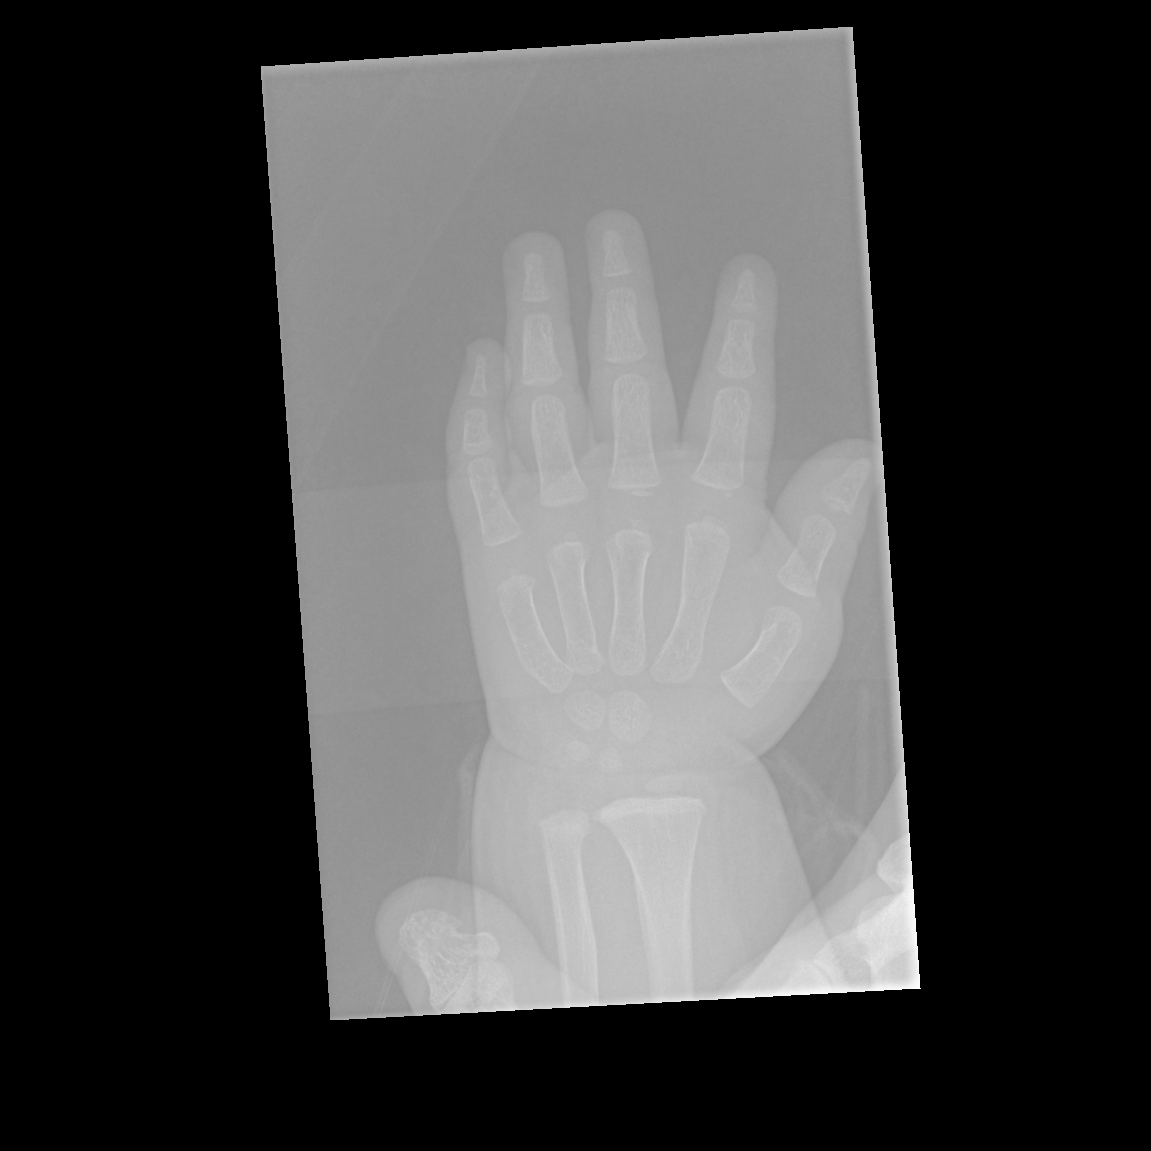

8583.png


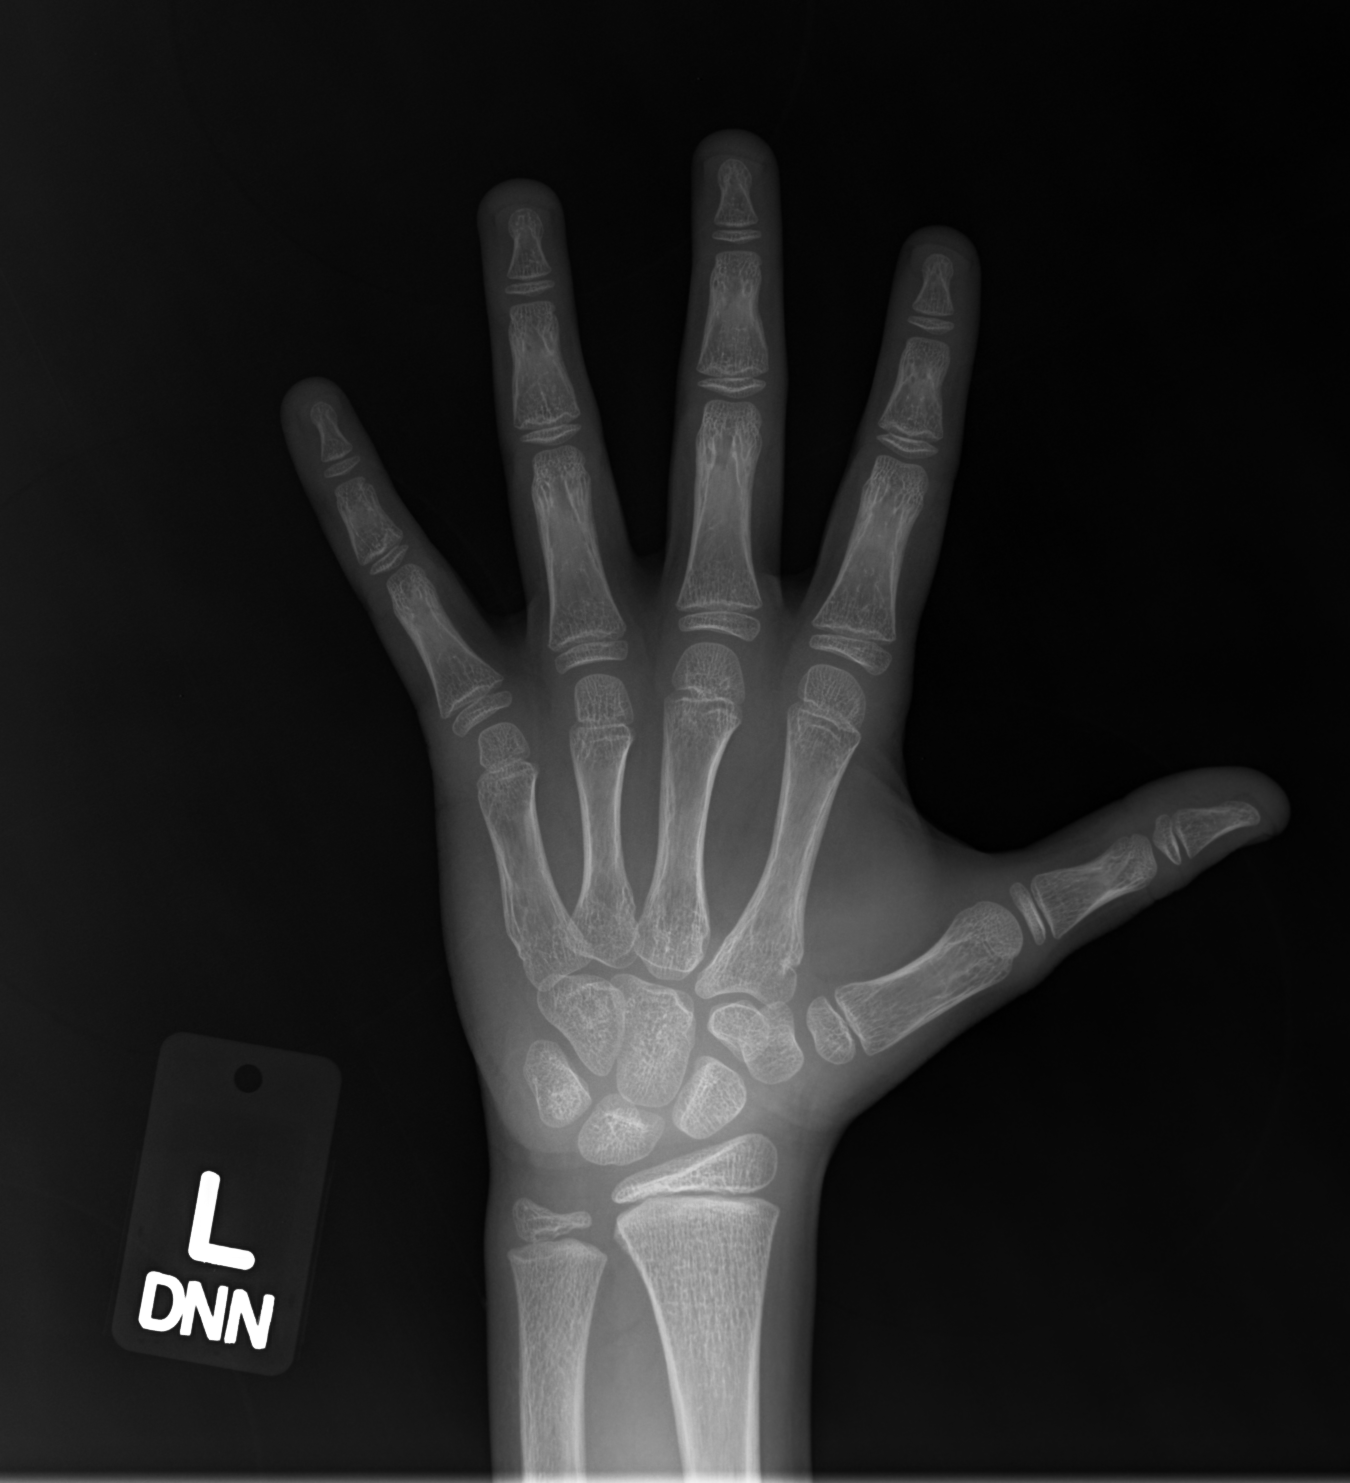

In [19]:
#Display the images
for i in range(40, 42):
    print(files[i])
    display(_Imgdis(filename=data + "/" + files[i], width=240, height=320))

In [20]:
train = []
test = []
train = [file for file in files]
test = [file for file in test_files]

print("Number of files in train set: %d" % len(train), "Number of files in test set: %d" % len(test))

Number of files in train set: 12611 Number of files in test set: 200


In [0]:
#Creating dataframe for image datasets as train and test by converting train and test lists to DataFrame
image_dataframe = pd.DataFrame(data = train, index=None,columns = None)
image_test_dataframe = pd.DataFrame(data = test,index=None,columns = None)

###### Read csv files that iclude boneage, gender and ID number of patients that are differed in test and train files.

In [0]:
dataframe = pd.read_csv("/content/boneage-training-dataset.csv") 
test_dataframe = pd.read_csv("/content/boneage-test-dataset.csv")

training = pd.concat([image_dataframe,dataframe],axis = 1)  #We merged two dataframes to make prediction clear
testing = pd.concat([image_test_dataframe,test_dataframe],axis = 1)

In [0]:
training = training.rename(index=str, columns={0: "images"}) #we changed the column named by 0 to "images"
testing = testing.rename(index=str, columns={0: "images"}) 

In [25]:
testing.head()

,images,Case ID,Sex
0,4461.png,4360,M
1,4374.png,4361,M
2,4559.png,4362,M
3,4529.png,4363,M
4,4397.png,4364,M


###### In this step we started to define label and feature.

In [0]:
label = training[['boneage']].copy() #label with "boneage" column.
feature_train = training.drop(columns = ['boneage'],axis = 1) #feature "without" boneage column.

In [0]:
img_width = 320
img_height = 240
ratio = 4

img_width_2 = int(img_width / ratio)
img_height_2 = int(img_height / ratio)

count = 3
nb_classes = 1
shape_feature = len(feature_train)
shape_test = len(testing)

new_dataset = np.ndarray(shape=(shape_feature, count, img_height_2, img_width_2),dtype=np.float32) #convert all image dimensions to numpy array.
new_test_dataset = np.ndarray(shape=(shape_test, count, img_height_2, img_width_2),dtype=np.float32)

In [28]:
print("Shape of Train Values : " + str(feature_train.shape))
print("Shape of Test Values: " + str(testing))

Shape of Train Values : (12611, 3)
Shape of Test Values:        images  Case ID Sex
0    4461.png     4360   M
1    4374.png     4361   M
2    4559.png     4362   M
3    4529.png     4363   M
4    4397.png     4364   M
..        ...      ...  ..
195  4410.png     4555   F
196  4478.png     4556   F
197  4382.png     4557   F
198  4450.png     4558   F
199  4424.png     4559   F

[200 rows x 3 columns]


In [29]:
i = 0
for _file in training['images']:
    img = load_img(data + "/" + _file,grayscale=False,target_size=[60,80],interpolation='nearest')  # this is a PIL image
    img.thumbnail((img_width_2, img_height_2))
    # Convert to Numpy Array
    x = img_to_array(img)  
    x = x.reshape((3, 60, 80))
    #Normalize
    x = (x - 128.0) / 128.0
    new_dataset[i] = x
    i += 1
    if i % 250 == 0:
      print("%d images to array" % i)
print("All TRAIN images to array!")

j = 0
for _file in testing['images']:
    img = load_img(test_data + "/" + _file,grayscale=False,target_size=[60,80],interpolation='nearest')  # this is a PIL image
    img.thumbnail((img_width_2, img_height_2))
    # Convert to Numpy Array
    x = img_to_array(img)  
    x = x.reshape((3, 60, 80))
    #Normalize
    x = (x - 128.0) / 128.0
    new_test_dataset[j] = x
    j += 1
    if j % 250 == 0:
        print("%d images to array" % j)
print("All TEST images to array!")

250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
3500 images to array
3750 images to array
4000 images to array
4250 images to array
4500 images to array
4750 images to array
5000 images to array
5250 images to array
5500 images to array
5750 images to array
6000 images to array
6250 images to array
6500 images to array
6750 images to array
7000 images to array
7250 images to array
7500 images to array
7750 images to array
8000 images to array
8250 images to array
8500 images to array
8750 images to array
9000 images to array
9250 images to array
9500 images to array
9750 images to array
10000 images to array
10250 images to array
10500 images to array
10750 images to array
11000 images to array
11250 images to array
11500 images to array
11750 images to array
12000 im

###### We falleted the array of image dimensions and fit them to their right dimesions.

In [30]:
flatted_image = new_dataset.flatten().reshape((new_dataset.shape[0],3*60*80)) #dataset.shape[0] provides us the total size of training.
flatted_test_image = new_test_dataset.flatten().reshape((new_test_dataset.shape[0],3*60*80))
flatted_image.shape

(12611, 14400)

In [31]:
flatted_image

array([[-0.765625 , -0.765625 , -0.765625 , ..., -0.7265625, -0.7265625,
        -0.7265625],
       [-0.9765625, -0.9765625, -0.9765625, ...,  0.453125 ,  0.453125 ,
         0.453125 ],
       [-0.90625  , -0.90625  , -0.90625  , ..., -0.75     , -0.75     ,
        -0.75     ],
       ...,
       [-0.9296875, -0.9296875, -0.9296875, ..., -1.       , -1.       ,
        -1.       ],
       [-0.1875   , -0.1875   , -0.1875   , ..., -1.       , -1.       ,
        -1.       ],
       [ 0.453125 ,  0.453125 ,  0.453125 , ..., -0.1171875, -0.1171875,
        -0.1171875]], dtype=float32)

In [0]:
label = label.values

###### We used Keras package which provides Sequential model that is a way of creating deep learning models where the instance of the classes and model layers created and added to it.

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, Flatten
from keras.layers.core import Lambda, Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

###### Creating Sequential model and defining Multilayer Perceptron.

In [34]:
seq_model = Sequential()

#Create an input layer with Dense function by using flatted image as input and reLu activation function.
seq_model.add(Dense(128,kernel_initializer='normal',input_dim=flatted_image.shape[1],  activation='relu'))
#Create two hidden layer with Dense function and also using reLu function.
seq_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
seq_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
#Create output layer with linear function.
seq_model.add(Dense(1,kernel_initializer='normal', activation='linear'))

print(seq_model.summary()) #summary of layers




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1843328   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 1,942,401
Trainable params: 1,942,401
Non-trainable params: 0
_________________________________________________________________
None


###### We need to compile network to make sure how good the network is by using loss function and applied some data so decreases loss value with optimizer then display the performance with metrics.

In [0]:
#Specified metric using Mean Squared Error and Mean Absolute Error.
seq_model.compile(loss= 'mean_absolute_error',optimizer = 'adam', metrics = ['mean_absolute_error'])

In [38]:
#fit/train the model
seq_model.fit(flatted_image,label,epochs= 10)

Epoch 1/10
12611/12611 [==============================] - 13s 998us/step - loss: 35.0791 - mean_absolute_error: 35.0791
Epoch 2/10
12611/12611 [==============================] - 12s 978us/step - loss: 34.7533 - mean_absolute_error: 34.7533
Epoch 3/10
12611/12611 [==============================] - 12s 965us/step - loss: 34.5805 - mean_absolute_error: 34.5805
Epoch 4/10
12611/12611 [==============================] - 12s 976us/step - loss: 34.5067 - mean_absolute_error: 34.5067
Epoch 5/10
12611/12611 [==============================] - 12s 966us/step - loss: 34.5121 - mean_absolute_error: 34.5121
Epoch 6/10
12611/12611 [==============================] - 12s 968us/step - loss: 34.1893 - mean_absolute_error: 34.1893
Epoch 7/10
12611/12611 [==============================] - 12s 973us/step - loss: 34.4587 - mean_absolute_error: 34.4587
Epoch 8/10
12611/12611 [==============================] - 12s 973us/step - loss: 34.2447 - mean_absolute_error: 34.2447
Epoch 9/10
12611/12611 [================

In [0]:
prediction = seq_model.predict(flatted_test_image) #Make prediction on our test images.

In [77]:
prediction[0]

array([88.9766], dtype=float32)

In [98]:
train_loss, train_acc = seq_model.evaluate(flatted_image,  label, verbose=2) #Get the accuracy of sequential model.

print('\nTrain accuracy:', test_acc)


Train accuracy: 33.73390321320937


In [0]:
graph = pd.concat([image_dataframe[:200],dataframe[:200]],axis = 1) #take the first 200 data from dataframe to use them in graph
graph = graph.rename(index=str, columns={0: "images"})

In [0]:
label_graph= graph[['boneage']].copy() #label with "boneage" column.
feature_graph = graph.drop(columns = ['boneage'],axis = 1) #feature "without" boneage column.

In [134]:
label_graph.shape

(200, 1)

Plot the graph of predicted datas

In [0]:
import matplotlib.pyplot as plt

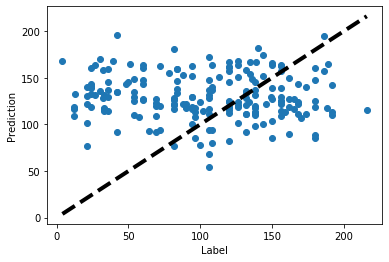

In [136]:
fig, ax = plt.subplots()
ax.scatter(label_graph, prediction)
ax.plot([label_test.min(), label_graph.max()], [label_graph.min(), label_graph.max()], 'k--', lw=4)
ax.set_xlabel('Label')
ax.set_ylabel('Prediction')
plt.show()

###### In this step, model was predicted.

###### This Step include Convolutional Neural Network for image classification.

###### CONCLUSION: For our project we completed great tasks. We cleaned and reorganize our data. We diveded into labels. We did preprocessing, we created our dataframes. Moreover we created Sequential Model and defined Multilayer Perceptron in order to fit our data. Lasltly we did some accurancy measurements and did optimizations. 